##**FAKE FACE GENERATION USING GAN**

**INTRODUCTION :**
Generative Adversarial Networks (GANs) are generative models. They are uses unsupervised technique to generate new things. GAN models learns pattern in input data in such a way that they can generate new sample which resemble with the input data. The main aim of generative adversarial network is to match generated distribution with the original data distribution.

GANs are an exciting and rapidly changing field, delivering generative models ability to generate realistic examples across a range of problem domains, most notably in image-to-image translation tasks such as translating photos of summer to winter or day to night,coloring images and in generating fake photos that even human cannot categorized as fake image. This site uses GAN to generate fake human faces which are similar to real human

**FLOW CHAR OF THE FAKE FACE GENERATION :**
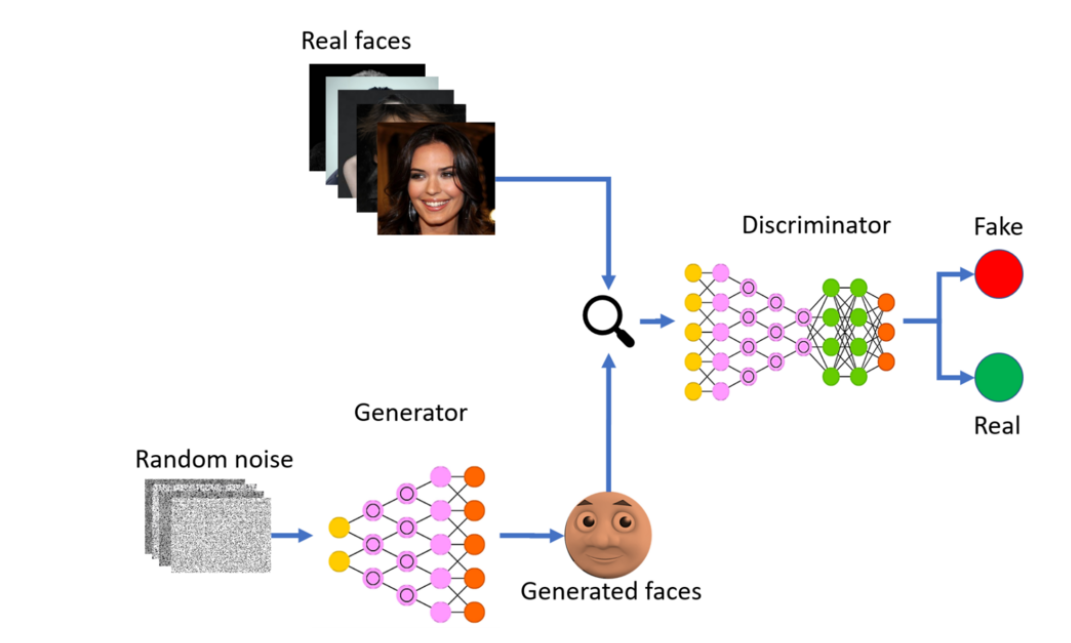

**COMPONENTS OF GAN:**

**Generator :** Generator are neural network that learns to generate data which resemble with the input distribution. The generator model take fixed dimension random vector from Gaussian distribution as input and generate the sample out of it which resemble with input.

**Discriminator :** Discriminator are simple neural network that distinguish fake and real data.The discriminator model takes an example from the domain as input (real or generated) and predicts a binary class label of real or fake.

Generative adversarial networks are based on a game theoretic scenario in which the generator network must compete against an adversary. The generator network directly produces samples. Its adversary, the discriminator network, attempts to distinguish between samples drawn from the training data and samples drawn from the generator.



####**WORKING OF GAN:**

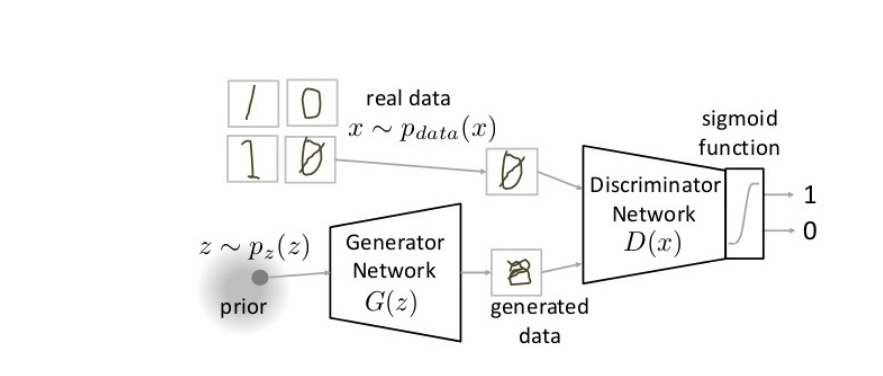

First of all we take batch of random vector from the Gaussian distribution and generate fake image out of it using generator. Since generator isn't trained so generated image donot resemble with the real input distribution. We take batches of image from the input distribution along with generated fake images and fed it to discriminator so that it learns to distinguish between real and fake images. Now, after training discriminator, we take the batch of images that generator generated and fed them through discriminator again (here we donot fed real images), discriminator will provide an output probabilities, these values are then compared with the probability that the generator should generated (ie 1), error is calculated and backpropagated through the generator and the weight are updated. This above process is repeated until generated images resemble with the input distribution.

####**APPLICATIONS OF GAN:**

1.   Generating Fake faces
2.   Generating examples for image Datasets
3.   Face aging
4.   Super Resolution
5.   Image to Image Translation
6.  Photos to Emojis
7.  Text to Image Tranlation
8.  Generate cartoon characters



**connect the google drive:**

In [ ]:
from google.colab import files
src = list(files.upload().values())[0]
open('mylib.py','wb').write(src)
import mylib

Saving problem_unittests.py to problem_unittests.py


**Import Necessary Libraries:**

**Load the data:**

In [ ]:
!unzip drive/My\ Drive/processed-celeba-small
data_dir = 'processed_celeba_small/'

import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests

%matplotlib inline

Streaming output truncated to the last 5000 lines.
  inflating: processed_celeba_small/celeba/New Folder With Items/052332.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052333.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052334.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052335.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052336.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052337.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052338.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052339.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052340.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052341.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052342.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052343.jpg  
  inflating: 

**Connected to the google drive:**

In [ ]:
import torch
from torchvision import datasets
from torchvision import transforms
from google.colab import drive
drive.mount('/content/gdrive') 

Mounted at /content/gdrive


In [ ]:
def get_dataloader(batch_size, image_size, data_dir=data_dir):

    transform = transforms.Compose([transforms.Resize(image_size),transforms.ToTensor()])
    data = datasets.ImageFolder(data_dir,transform = transform)
    
    dataLoader = torch.utils.data.DataLoader(data,batch_size = batch_size, shuffle= True)
    
    return dataLoader

In [ ]:
batch_size = 64
img_size = 32

celeba_train_loader = get_dataloader(batch_size, img_size)

**Visalize our images:**

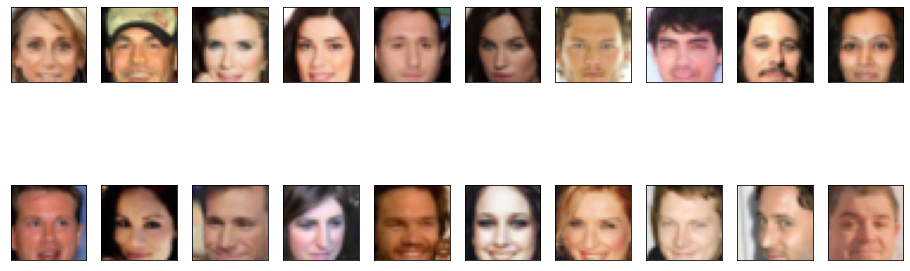

In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(celeba_train_loader)
images, _ = dataiter.next()
fig = plt.figure(figsize=(16, 6))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

In [ ]:
def scale(x, feature_range=(-1, 1)):
    x = x*2 - 1
    return x

In [ ]:
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9765)
Max:  tensor(0.9529)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
def conv(in_channels,out_channels,kernel_size=4,stride = 2,padding=1,batch_norm = True):
  
    layer = list()
    layer.append(nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding))
  
    if(batch_norm):
        layer.append(nn.BatchNorm2d(out_channels))
  
    return nn.Sequential(*layer)

In [ ]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):

        self.conv_dim  = conv_dim
        
        super(Discriminator, self).__init__()

        self.conv1 = conv(3,conv_dim,4,2)     
        self.conv2 = conv(conv_dim,conv_dim*2,4,2)    
        self.conv3 = conv(conv_dim*2,conv_dim*4,4,2)   
        self.conv4 = conv(conv_dim*4,conv_dim*8,4,2,batch_norm=False)  
        
        self.fc1 = nn.Linear(2*2*conv_dim*8,512)
        self.fc2 = nn.Linear(512,1)
        
        self.drp = nn.Dropout(0.3)

    def forward(self, x):

        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
        
        x = x.reshape(-1,2*2*self.conv_dim*8)
        x = F.leaky_relu(self.fc1(x))
        x = self.drp(x)
        x = self.fc2(x)
        
        return x

tests.test_discriminator(Discriminator)

Tests Passed


In [ ]:
def deconv(in_channels,out_channels,kernel_size=4,stride = 2,padding=1,batch_norm = True):
  
    layer = list()
    layer.append(nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,padding))

    if(batch_norm):
        layer.append(nn.BatchNorm2d(out_channels))

    return nn.Sequential(*layer)

**Generator:**

Here, I have defined generator network. It take random vector from normal distribution as input. This random vector is passed through dense layer and is reshaped and is finally fed through Convolution layers.

The final output layer of Generator generate 12 by 12 by 10 image. The final layer of generator uses hyperbolic tangent as activation to squash the value in between -1 and 1. Generator model looks like simple autoencoder model, where input data is downsampled first and is finally upsampled .

In [ ]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):

        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim = 1024
        self.fc1 = nn.Linear(z_size,1*1*conv_dim)
        
        self.conv1 = deconv(conv_dim,conv_dim//2,4,2)     
        self.conv2 = deconv(conv_dim//2,conv_dim//4)           
        self.conv3 = deconv(conv_dim//4,conv_dim//8)            
        self.conv4 = deconv(conv_dim//8,conv_dim//16)            
        self.conv5 = deconv(conv_dim//16,3,batch_norm = False)  

    def forward(self, x):
        
        x = F.leaky_relu(self.fc1(x))
        x = x.reshape(-1,self.conv_dim,1,1)
        
        x = F.leaky_relu(self.conv1(x))
        
        x = F.leaky_relu(self.conv2(x))
        
        x = F.leaky_relu(self.conv3(x))
        
        x = F.leaky_relu(self.conv4(x))
        
        x = torch.tanh(self.conv5(x))
        
        
        return x

tests.test_generator(Generator)

Tests Passed


In [ ]:
def weights_init_normal(m):

    classname = m.__class__.__name__
    
    if classname.find('Linear') != -1 or classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.fill_(0)
     

In [ ]:
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G

**Discriminator:**

Here, discriminator model take 12 by 12 by 10 image that can be real or generated. This input image is downsampled using Convolution layer and is finally flattened and is fed to single neuron so that it can distinguish real and fake image. Since, final layer uses sigmoid function as activation, it output value in between 0 and 1. Here value greater than 0.5 refers to real and less than 0.5 refers to fake image. The output of discriminator is used in training of generator.

In [ ]:
d_conv_dim = 64
g_conv_dim = 1024
z_size = 100 

D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (drp): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=100, out_features=1024, bias=True)
  (conv1): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel

In [ ]:
import torch

train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

No GPU found. Please use a GPU to train your neural network.


In [ ]:
def real_loss(D_out):

    criterian = nn.BCEWithLogitsLoss()
    target = torch.ones(*D_out.shape)
    
    if train_on_gpu:
        target = target.cuda()
    loss = criterian(D_out,target)
    return loss

def fake_loss(D_out):

    criterian = nn.BCEWithLogitsLoss()
    target = torch.zeros(*D_out.shape)
    
    if train_on_gpu:
        target = target.cuda()
    loss = criterian(D_out,target)
    return loss

In [ ]:
import torch.optim as optim

d_optimizer = optim.Adam(D.parameters(),lr = 0.0002)
g_optimizer = optim.Adam(G.parameters(),lr = 0.0002)

In [ ]:
def train(D, G, n_epochs, print_every=50):

    if train_on_gpu:
        D.cuda()
        G.cuda()

    samples = []
    losses = []

    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()

    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    for epoch in range(n_epochs):

        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            d_optimizer.zero_grad()
            
            if train_on_gpu:
                real_images = real_images.cuda()
                
            d_out = D(real_images)
            d_real_loss = real_loss(d_out)
            
            z = np.random.uniform(-1, 1, size=(sample_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
            fake_out = G(z)
            
            g_fake_loss = fake_loss(D(fake_out))
            
            d_loss = d_real_loss + g_fake_loss 
            d_loss.backward()
            d_optimizer.step()

            g_optimizer.zero_grad()
            
            g_out = G(z)
            d_real_out = D(g_out)
            g_loss = real_loss(d_real_out)
            
            g_loss.backward()
            g_optimizer.step()

            if batch_i % print_every == 0:
                losses.append((d_loss.item(), g_loss.item()))
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))

        G.eval()
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train()

    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)

    return losses

**Function to plot generated images**

In [ ]:
n_epochs = 10

losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   10] | d_loss: 1.3640 | g_loss: 1.1301
Epoch [    1/   10] | d_loss: 0.0894 | g_loss: 13.9573
Epoch [    1/   10] | d_loss: 0.0003 | g_loss: 14.4685
Epoch [    1/   10] | d_loss: 0.0233 | g_loss: 14.3938
Epoch [    1/   10] | d_loss: 0.0325 | g_loss: 29.3438
Epoch [    1/   10] | d_loss: 0.0424 | g_loss: 9.5350
Epoch [    1/   10] | d_loss: 0.0001 | g_loss: 16.2352
Epoch [    1/   10] | d_loss: 0.5382 | g_loss: 9.9278
Epoch [    1/   10] | d_loss: 0.2616 | g_loss: 8.2812
Epoch [    1/   10] | d_loss: 0.0602 | g_loss: 9.8752
Epoch [    1/   10] | d_loss: 0.0005 | g_loss: 11.0017
Epoch [    1/   10] | d_loss: 0.0140 | g_loss: 11.4115
Epoch [    1/   10] | d_loss: 0.0047 | g_loss: 9.4238
Epoch [    1/   10] | d_loss: 0.0008 | g_loss: 11.0949
Epoch [    1/   10] | d_loss: 0.1753 | g_loss: 15.7868
Epoch [    1/   10] | d_loss: 0.0024 | g_loss: 8.2761
Epoch [    1/   10] | d_loss: 0.0000 | g_loss: 12.3490
Epoch [    1/   10] | d_loss: 0.0002 | g_loss: 9.8728
Epoch [    1/   10

**Labeling the generator and discriminator by Training the dataset:**

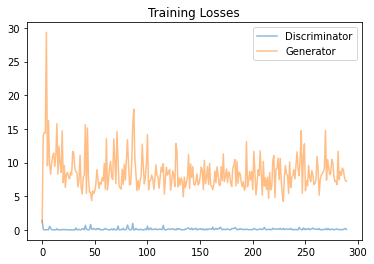

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [ ]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [ ]:
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

**Some generated images:**

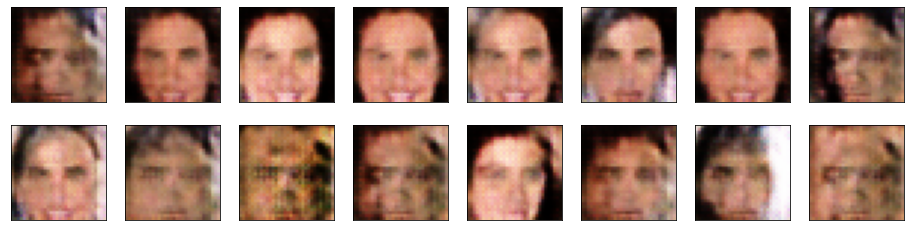

In [ ]:
_ = view_samples(-1, samples)

#**THANK YOU**